In [69]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from itertools import combinations
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-02-27 02:24:32,954: Credentials are already in use. The existing account in the session will be replaced.


In [70]:
# useful additional packages
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

In [71]:
with open('dataset.json') as json_file:
    data = json.load(json_file)

In [72]:
num_city = 15
num_conn = 5
num_pow = 4 # max=8

In [73]:
keys = list(data.keys())[:num_city]
# keys

In [74]:
M = num_city*[num_conn*[0]]
M_np = np.array(M)
# print(M_np)
i, j = 0, 0
for m in keys:
    j = 0
    keys2 = list(data[m].keys())[:num_conn]
    for n in keys2:
        M_np[i,j] = data[m][n]
        j += 1
    i += 1
M_np

array([[  0,  34, 711, 281, 460],
       [ 34,   0, 720, 276, 466],
       [711, 720,   0, 473, 255],
       [281, 276, 473,   0, 220],
       [460, 466, 255, 220,   0],
       [ 73,  57, 670, 218, 415],
       [242, 210, 724, 255, 475],
       [710, 718,  19, 467, 252],
       [454, 462, 258, 223,  15],
       [695, 708,  88, 483, 263],
       [607, 615, 105, 369, 150],
       [598, 613, 159, 404, 193],
       [639, 650,  84, 418, 197],
       [623, 634,  90, 396, 175],
       [402, 409, 312, 173,  58]])

In [75]:
N = num_city*[num_conn*[0]]
N_np = np.array(M)
# print(N_np)

i, j = 0, 0
for m in keys:
    j = 0
    keys2 = list(data[m].keys())[-num_pow:]
    for n in keys2:
        # print(data[m][n])
        N_np[i,j] = data[m][n]
        j += 1
    i += 1
N_np

array([[   8263835,    3328756,    7387769,    2790349,          0],
       [  42830135, 1204777798,  452338114,    7073097,          0],
       [   3163245,     569993,          0,          0,          0],
       [  34125633,  255192991,          0,    3109118,          0],
       [   8811023,   12956616,          0,    2260981,          0],
       [  37674835,   47607923,          0,    7249568,          0],
       [   6924953,  882966913,          0,  677650443,          0],
       [  65665225,      16301,          0,          0,          0],
       [  13197682,    1833868,          0,          0,          0],
       [  38694302,     114107,          0,          0,          0],
       [ 136388531,    4225640,          0,          0,          0],
       [  13527380,      75282,          0,          0,          0],
       [   5570478,       6463,          0,          0,          0],
       [   4551512,      13584,          0,          0,          0],
       [  21153331,   90489885,   

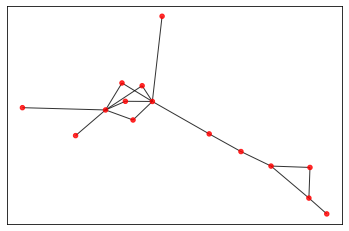

In [76]:
n = num_city  # Number of nodes in graph
G = nx.Graph()

data = M_np
for i in range(num_city):
    for j in range(num_conn):
        # print(data[i,j])
        # weight=round(data[i,j],2)
        weight=data[i,j]
        if(weight<220):
            G.add_edge(i,j,weight=weight)
        

colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=20, alpha=0.8, ax=default_axes, pos=pos, with_labels=False)

draw_graph(G, colors, pos)        


In [82]:
Q = num_city*[num_city*[0]]
Q = np.array(Q)

gamma = 10 / len(G.nodes)

gamma = 100

# Fill in Q matrix
for u, v in G.edges:
    Q[u,u] += -2*G.get_edge_data(u, v)["weight"]
    Q[v,v] += -2*G.get_edge_data(u, v)["weight"]
    Q[u,v] += 8*G.get_edge_data(u, v)["weight"]

for i in G.nodes:
    Q[i,i] += gamma*(1-len(G.nodes))

for i, j in combinations(G.nodes, 2):
    Q[i,j] += 2*gamma

In [83]:
max_cut = Maxcut(Q)
qp = max_cut.to_quadratic_program()
# print(qp.export_as_lp_string())

In [84]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
# print(str(qubitOp))

Offset: -18892.0
Ising Hamiltonian:


In [85]:
# solving Quadratic Program using exact classical eigensolver
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result)

optimal function value: 27440.0
optimal value: [1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
status: SUCCESS


energy: -8548.0
max-cut objective: -27440.0
solution: [1 1 1 1 1 0 0 1 1 0 0 0 0 0 0]
solution objective: 27440.0


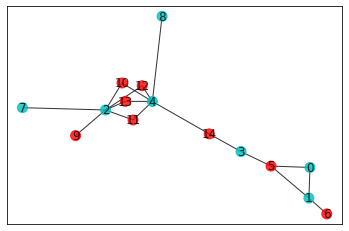

In [88]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

colors = ["r" if x[i] == 0 else "c" for i in range(n)]

def draw_graph(G, colors, pos):
    nx.draw_networkx(G, node_color=colors, node_size=100, alpha=0.8, pos=pos)
    
draw_graph(G, colors, pos)

In [ ]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

In [ ]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution objective:", qp.objective.evaluate(x))

# plot results
colors = ["r" if x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

In [ ]:
# create minimum eigen optimizer based on VQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ["r" if result.x[i] == 0 else "c" for i in range(n)]
draw_graph(G, colors, pos)